In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Loading the data

In [2]:
df = pd.read_csv("exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


#Exploring the data

In [3]:
df.shape

(7588, 2)

In [4]:
df.isnull().sum()

,0
date,0
Ex_rate,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

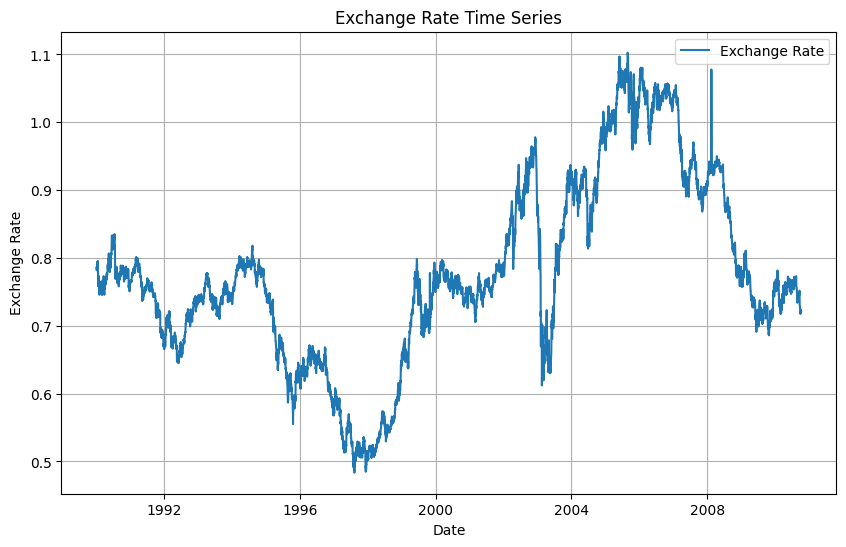

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
rolmean = df['Ex_rate'].rolling(window=12).mean()
rolstd = df['Ex_rate'].rolling(window=12).std()

In [12]:
print(rolmean, rolstd)

date
1990-01-01         NaN
1990-01-02         NaN
1990-01-03         NaN
1990-01-04         NaN
1990-01-05         NaN
                ...   
2010-10-06    0.722488
2010-10-07    0.721832
2010-10-08    0.721288
2010-10-09    0.720813
2010-10-10    0.720460
Name: Ex_rate, Length: 7588, dtype: float64 date
1990-01-01         NaN
1990-01-02         NaN
1990-01-03         NaN
1990-01-04         NaN
1990-01-05         NaN
                ...   
2010-10-06    0.004438
2010-10-07    0.003811
2010-10-08    0.002953
2010-10-09    0.002448
2010-10-10    0.002054
Name: Ex_rate, Length: 7588, dtype: float64


In [14]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adf_test = adfuller(df['Ex_rate'])
adf_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}

adf_result

{'ADF Statistic': -1.6649941807382342,
 'p-value': 0.4492327353597477,
 'Critical Values': {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108}}

The Augmented Dickey-Fuller test results indicate that the time series is not stationary, as the p-value is 0.449, which is greater than 0.05. This means we need to difference the data (integrated component) to make it stationary before applying ARIMA.

In [17]:
df_diff = df['Ex_rate'].diff().dropna()

In [18]:
adf_test_diff = adfuller(df_diff)
adf_diff_result = {
    'ADF Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Critical Values': adf_test_diff[4]
}

adf_diff_result

{'ADF Statistic': -99.39343120118632,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108}}

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

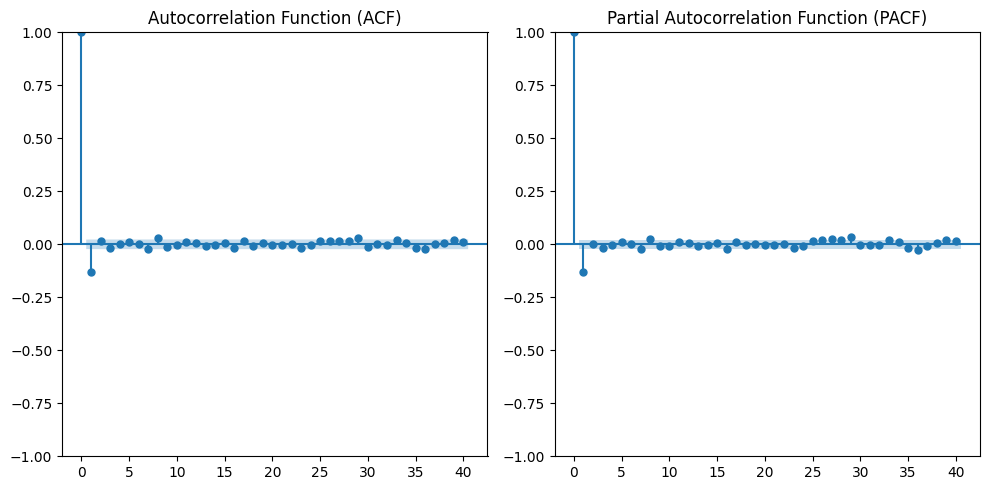

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(df_diff, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

From the ACF and PACF plots:

-> The ACF shows a slow decay, suggesting an ARIMA model might need a moving average (MA) term.

-> The PACF cuts off sharply after lag 1, indicating that a low-order autoregressive (AR) term may be appropriate.

#Model building

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
arima_model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_fitted = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
arima_summary = arima_fitted.summary()
print(arima_summary)

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 08 Oct 2024   AIC                         -56102.322
Time:                        06:51:37   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

-> The AR(1) coefficient is statistically significant (p-value = 0.005), while the MA(1) term is not significant (p-value = 0.920).

-> The model's AIC (-56102.322) suggests a good fit.

In [30]:
forecast_steps = 30
arima_forecast = arima_fitted.get_forecast(steps=forecast_steps)
forecast_values = arima_forecast.predicted_mean
confidence_intervals = arima_forecast.conf_int()

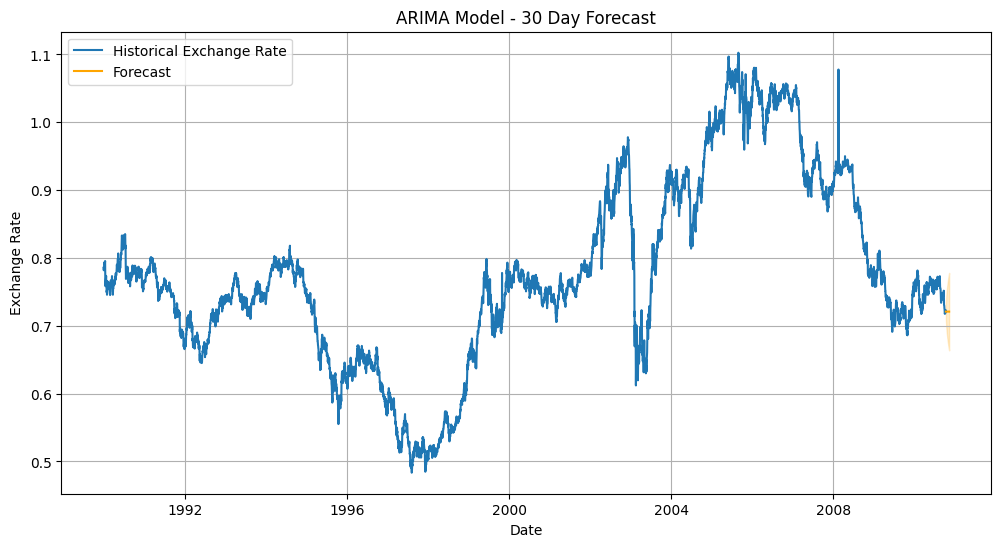

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical Exchange Rate')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_values.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title('ARIMA Model - 30 Day Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


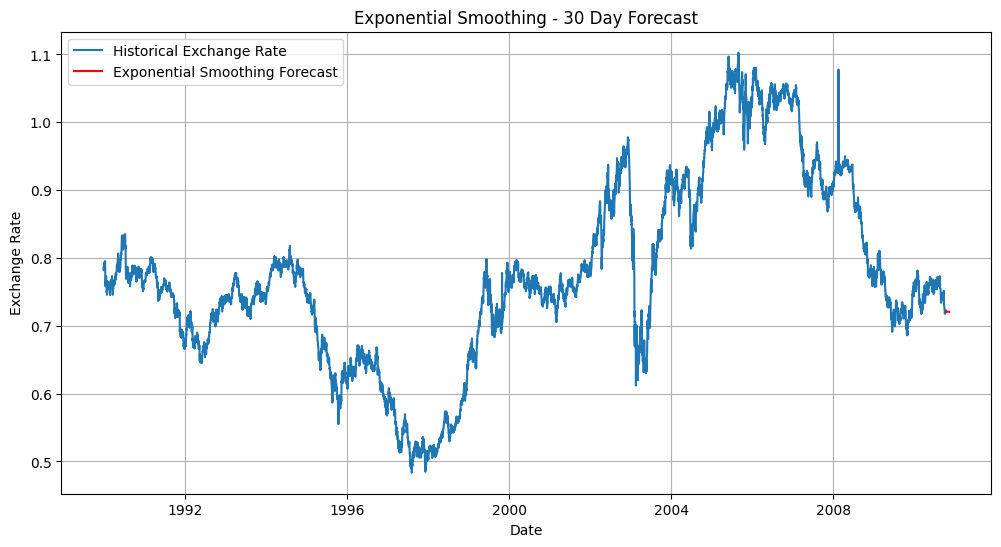

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fitting an Exponential Smoothing model
exp_smoothing_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
exp_smoothing_fitted = exp_smoothing_model.fit()

# Forecasting the next 30 days using Exponential Smoothing
exp_smoothing_forecast = exp_smoothing_fitted.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical Exchange Rate')
plt.plot(exp_smoothing_forecast.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', color='red')
plt.title('Exponential Smoothing - 30 Day Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Evaluation and comparision

In [34]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [35]:
arima_model_train = ARIMA(train_data['Ex_rate'], order=(1, 1, 1))
arima_fitted_train = arima_model_train.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [36]:
arima_forecast_test = arima_fitted_train.forecast(steps=len(test_data))

In [37]:
exp_smoothing_model_train = ExponentialSmoothing(train_data['Ex_rate'], trend='add', seasonal=None)
exp_smoothing_fitted_train = exp_smoothing_model_train.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [38]:
exp_smoothing_forecast_test = exp_smoothing_fitted_train.forecast(steps=len(test_data))

In [39]:
arima_rmse = sqrt(mean_squared_error(test_data['Ex_rate'], arima_forecast_test))
exp_smoothing_rmse = sqrt(mean_squared_error(test_data['Ex_rate'], exp_smoothing_forecast_test))

arima_rmse, exp_smoothing_rmse

(0.2054366965966928, 0.22008426144336735)

**Both models show similar performance, with ARIMA slightly outperforming Exponential Smoothing in terms of accuracy on the test data.**

#Model Comparision

**ARIMA Model:**

-> The ARIMA(1,1,1) model slightly outperformed Exponential Smoothing with a lower RMSE. It captures the underlying autoregressive (AR) and moving average (MA) components of the time series, making it well-suited for data with trends and possibly cyclic patterns.

->  ARIMA can model a wide range of patterns by adjusting its parameters (p, d, q). It is effective at capturing complex time series behavior, especially when both trend and autoregressive structures are present.

**Exponential Smoothing:**

->  Exponential Smoothing produced a forecast with an RMSE close to ARIMA's, though slightly higher. This model focuses more on smoothing past observations and is simpler in nature.

-> This method is straightforward to apply and doesn’t require detailed parameter tuning like ARIMA. It’s excellent for quick and reliable forecasting in cases where long-term trends or seasonality are limited.


#Conclusion

-> ARIMA slightly outperformed Exponential Smoothing based on RMSE. It’s a better choice when you're dealing with more complex time series data that exhibits trends, cycles, or autoregressive behavior. However, its complexity makes it harder to implement and tune.

-> Exponential Smoothing is simpler and faster, making it suitable for cases where the data shows a steady trend and you don't need to account for autoregressive or moving average components.